In [29]:
import glob
import numpy as np
import astropy.units as u
from astropy.time import Time

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline

In [3]:
import dynspectools as dtools
import psrchive

# Load an archive using psrchive

## If you are instead starting directly from a dynamic spectrum (.dspec), go to "Let's measure the size of scintles"  use dtools.read_psrflux()

The archive is a data cube of dimensions [time, pol, frequency, phase].  Typical pulsar diagnostic plots show t vs. phase and phase vs. frequency.  

We are after the "dynamic spectrum", which is simply the time vs. frequency.

For this tutotial we will ignore polarization.  The pols are ordered XX*, YY*, Re(XY*), Im(XY*) (or L and R if feeds are circular), so we sum the 0 and 1 pols to form the total intensity.



In [4]:
fname = '/fpra/bband/01/ramain/Eff_ScintArchives/20201110/B1508+55/6/2020-11-10-10:20:50.ar'

# Read and dedisperse archive
arch = psrchive.Archive_load(fname)
arch.dedisperse()

# Get the data
data = arch.get_data()

# Get the Frequency information
try:
    F = arch.get_frequencies()
except:
    midf = arch.get_centre_frequency()
    bw = arch.get_bandwidth()
    F = np.linspace(midf-bw/2., midf+bw/2., data.shape[2], endpoint=False)

# Get the time information
a = arch.start_time()
t0 = a.strtempo()
t0 = Time(float(t0), format='mjd', precision=0)

nt = data.shape[0]
Tobs = arch.integration_length()
dt = (Tobs / nt)*u.s
T = t0 + np.arange(nt)*dt
T = T.mjd

In [6]:
"""
Look at details of the observation
"""

print("data shape is {0}".format(data.shape))

print("Start time is {0}".format(t0.isot))

print("Observation Length is {0}s".format(Tobs) )

print("Frequency range is {0} - {1}".format(min(F), max(F)) )

data shape is (1079, 4, 2000, 128)
Start time is 2020-11-10T10:20:50
Observation Length is 10781.85536s
Frequency range is 1347.50622559 - 1372.49377441


# Steps to go from a data cube to a dynamic spectrum

Text(0,0.5,'time (bins)')

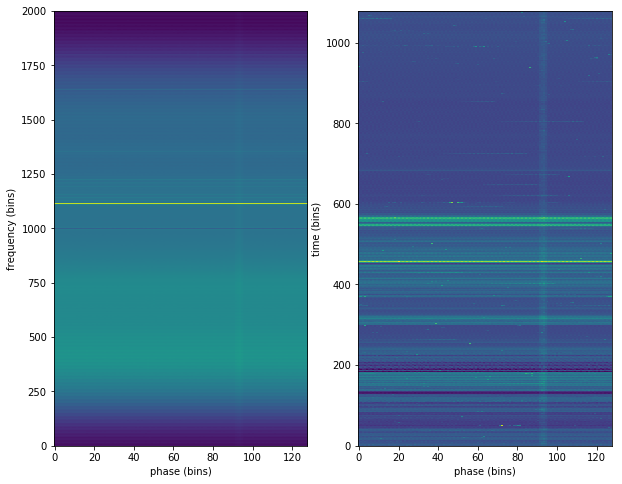

In [5]:
# First, sum pols to total intensity (if the data are full pol) 
# otherwise squeeze the len 1 pol axis away
if data.shape[1] > 1:
    I = data[:,(0,1)].mean(1)
else:
    I = data.squeeze()

# We now have data cube I with shape [time, freq, phase]
# Let's look at the folded profile!
    
plt.figure(figsize=(10,8))
plt.subplot(121)
# sum over time axis
plt.imshow(I.mean(0), aspect='auto', origin='lower')
plt.xlabel('phase (bins)')
plt.ylabel('frequency (bins)')

plt.subplot(122)
# sum over frequency axis
plt.imshow(I.mean(1), aspect='auto', origin='lower')
plt.xlabel('phase (bins)')
plt.ylabel('time (bins)')

# Let's try to remove the background, to see the pulsar more clearly


Text(0,0.5,'time (bins)')

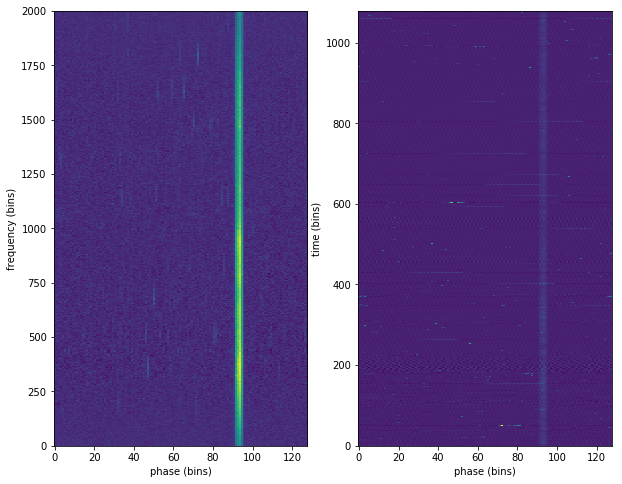

In [7]:
Iclean = I - np.mean(I, axis=-1, keepdims=True)

plt.figure(figsize=(10,8))
plt.subplot(121)
# sum over time axis
plt.imshow(Iclean.mean(0), aspect='auto', origin='lower')
plt.xlabel('phase (bins)')
plt.ylabel('frequency (bins)')

plt.subplot(122)
# sum over frequency axis
plt.imshow(Iclean.mean(1), aspect='auto', origin='lower')
plt.xlabel('phase (bins)')
plt.ylabel('time (bins)')

# Let's create the dynamic spectrum!

We've looked at I(f, phase), I(t, phase), the other slice is I(t, f) 
-- we just have to sum over the phase axis


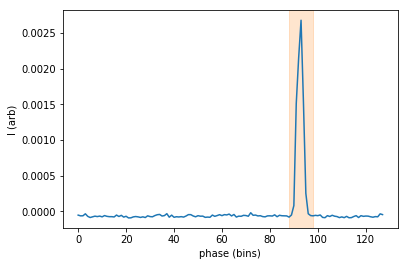

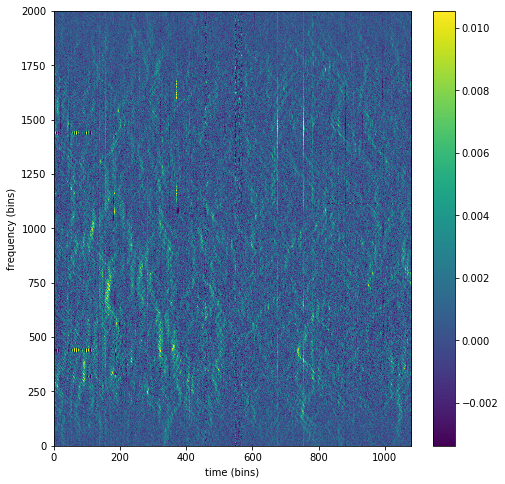

In [9]:
# Sum over time and frequency to obtain the total profile
profile = Iclean.mean(0).mean(0)
windowwidth = 5

# Find peak of profile, sum data in small window containing full pulse
peak = np.argmax(profile)
on_gates = slice(peak-windowwidth, peak+windowwidth)

plt.figure()
plt.plot(profile)
plt.axvspan(peak-windowwidth, peak+windowwidth, color='tab:orange', alpha=0.2)
plt.xlabel('phase (bins)')
plt.ylabel('I (arb)')

# To create the dynamic spectrum, sum over our on_gates
dynspec = Iclean[..., on_gates].mean(-1)

# Choose good min/max values to have a good dynamic range
mn = np.mean(dynspec)
std = np.std(dynspec)
vmin = mn - 3*std
vmax = mn + 7*std

plt.figure(figsize=(8,8))
plt.imshow(dynspec.T, aspect='auto', vmin=vmin, vmax=vmax, origin='lower')
plt.xlabel('time (bins)')
plt.ylabel('frequency (bins)')
plt.colorbar()

# Let's measure the characteristic time and frequency size of scintles

We will do this using the 2D Autocorrelation Function

To do this, we FFT, multiply, and iFFT the dynamic spectrum 

Remember convolution theorem - the dynspecs are multiplied in Fourier space, so they are convolved when IFTed


In [20]:
"""
If you are reading from a .dspec file, the above steps can be skipped.  
Use this function to read in your dynspec

"""
#fname = 'psrfluxfile.dspec'
#dynspec, dserr, T, F, psrname = dtools.read_psrflux(fname)

'\nIf you are reading from a .dspec file, the above steps can be skipped.  Use this function to read in your dynspec\n\n\n'

df = 0.576806102129 +- 0.00666490841613 MHz
dt = 2099.87374463 +- 0.480322251067, seconds


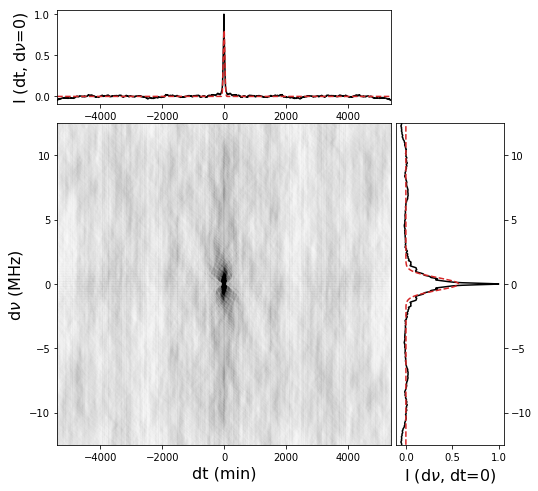

In [21]:
from scipy.optimize import curve_fit

def Gaussian(x, sigma, A, C):
    return A*np.exp( -x**2 / (2*sigma**2) ) + C


ccorr = np.fft.ifft2( np.fft.fft2(dynspec) * np.fft.fft2(dynspec).conj() )
# Im values are 0 anyways, so take the absolute value or real values
ccorr = abs(ccorr)

# Take slice through center of cross-correlation along frequency axis
# Ignoring zero component with noise-noise correlation
ccorr_f = ccorr[1] + ccorr[-1]
ccorr_f -= np.median(ccorr_f)
ccorr_f /= np.max(ccorr_f)
ccorr_f = np.fft.fftshift(ccorr_f)

# Take slice through center of cross-correlation along time axis
# Ignoring zero component with noise-noise correlation
ccorr_t = ccorr[:,1] + ccorr[:,-1]
ccorr_t -= np.median(ccorr_t)
ccorr_t /= np.max(ccorr_t)
ccorr_t = np.fft.fftshift(ccorr_t)

# Get the correct units
BW = max(F) - min(F)
df_axis = np.linspace(-BW/2., BW/2., len(F), endpoint=False)
dt_axis = np.linspace(-Tobs/2., Tobs/2., len(T), endpoint=False)


# Fit the slices in frequency and time with a Gaussian
# p0 values are just a starting guess
p0 = [5., 1, 0]
popt, pcov = curve_fit(Gaussian, df_axis, ccorr_f, p0=p0)

nuscint = abs(popt[0])
nuscint_err = np.sqrt(pcov[0,0])

fscint =  np.sqrt(2*np.log(2)) * nuscint
fscinterr =  np.sqrt(2*np.log(2)) * nuscint_err

pT = [20, 1, 0]
poptT, pcovT = curve_fit(Gaussian, dt_axis, ccorr_t, p0=p0)
tscint = np.sqrt(2) * abs(poptT[0]) * 60.
tscinterr = np.sqrt(2) * np.sqrt(pcov[0,0]) * 60.


# Find nice vmax, vmin values for plotting
vmax = np.mean(ccorr) + 10*np.std(ccorr)
vmin = np.mean(ccorr) - 3*np.std(ccorr)

plt.figure(figsize=(8,8))

ax1 = plt.subplot2grid((4, 4), (1, 0), colspan=3, rowspan=3)
ax2 = plt.subplot2grid((4, 4), (1, 3), rowspan=3)
ax3 = plt.subplot2grid((4, 4), (0, 0), colspan=3)

plt.subplots_adjust(wspace=0.05)

ax1.imshow(np.fft.fftshift(ccorr).T, aspect='auto', origin='lower',
          extent=[min(dt_axis), max(dt_axis), min(df_axis), max(df_axis)],
          vmax=vmax, vmin=vmin, cmap='Greys')

ax1.set_xlabel('dt (min)', fontsize=16)
ax1.set_ylabel(r'd$\nu$ (MHz)', fontsize=16)

ax2.plot( ccorr_f, df_axis, color='k')
ax2.plot(Gaussian(df_axis, popt[0], popt[1], popt[2]), df_axis, color='tab:red',
        linestyle='--')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel(r'I (d$\nu$, dt=0)', fontsize=16)
ax2.set_ylim(min(df_axis), max(df_axis) )

ax3.plot( dt_axis, ccorr_t, color='k')
ax3.plot( dt_axis, Gaussian(dt_axis, poptT[0], poptT[1], poptT[2]), color='tab:red',
          linestyle='--')
ax3.set_ylabel(r'I (dt, d$\nu$=0)', fontsize=16)
ax3.set_xlim(min(dt_axis), max(dt_axis))

print("df = {0} +- {1} MHz".format(fscint, fscinterr))
print("dt = {0} +- {1}, seconds".format(tscint, tscinterr))


# Look at Secondary Spectrum

The secondary spectrum is the squared modulus of the 2D FFT of the dynamic spectrum

It expresses the power in terms of the time delay and fringe rate between all pairs of interfering images

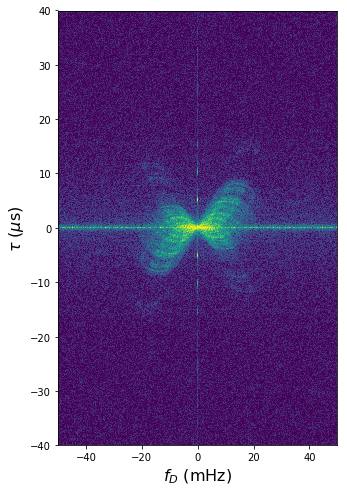

In [27]:
# Plotting choices, fiddle to look good
bintau = 4
binft = 1
vm = 3.
xlim = 0
ylim = 0

df = (F[1] - F[0])*u.MHz

CS = np.fft.fft2(dynspec)
S = np.abs(np.fft.fftshift(CS))**2.0    

Sb = S.reshape(-1,S.shape[1]//bintau, bintau).mean(-1)
if binft > 1:
    nftbin = Sb.shape[0]//binft
    print(Sb.shape)
    Sb = Sb[:binft*nftbin].reshape(nftbin, binft, -1).mean(1)
Sb = np.log10(Sb)

# Calculate the confugate frequencies (time delay, fringe rate), only used for plotting
ft = np.fft.fftfreq(S.shape[0], dt)
ft = np.fft.fftshift(ft.to(u.mHz).value)

tau = np.fft.fftfreq(S.shape[1], df)
tau = np.fft.fftshift(tau.to(u.microsecond).value)    

slow = np.median(Sb)-0.2
shigh = slow + vm

# Not the nicest, have a set of different plots it can produce
plt.figure(figsize=(5,8))

# Plot Secondary spectrum
plt.imshow(Sb.T, aspect='auto', vmin=slow, vmax=shigh, origin='lower',
           extent=[min(ft), max(ft), min(tau), max(tau)], interpolation='nearest',
          cmap='viridis')
plt.xlabel(r'$f_{D}$ (mHz)', fontsize=16)
plt.ylabel(r'$\tau$ ($\mu$s)', fontsize=16) 

if xlim:
    plt.xlim(-xlim, xlim)
if ylim:
    plt.ylim(-ylim, ylim)

# All together, without intermediate steps

Read archive of B1508+55 from /fpra/bband/01/ramain/Eff_ScintArchives/20201110/B1508+55/6/2020-11-10-10:20:50.ar
Dedispersing...
(1079, 4, 2000, 128)
(2158, 2000)
df = 0.575994709837 +- 0.157500732185 MHz
dt = 33.4948202847 +- 1.29067816654, seconds


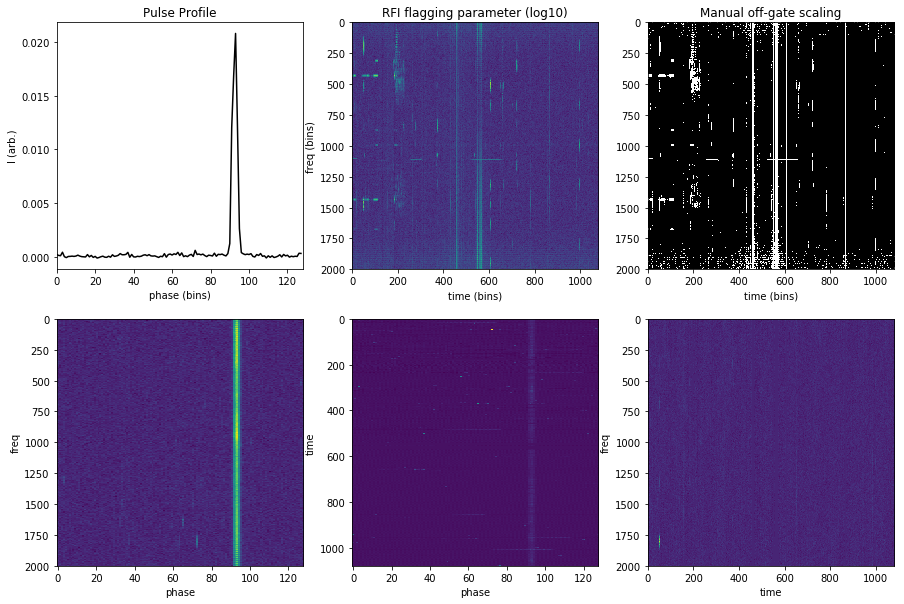

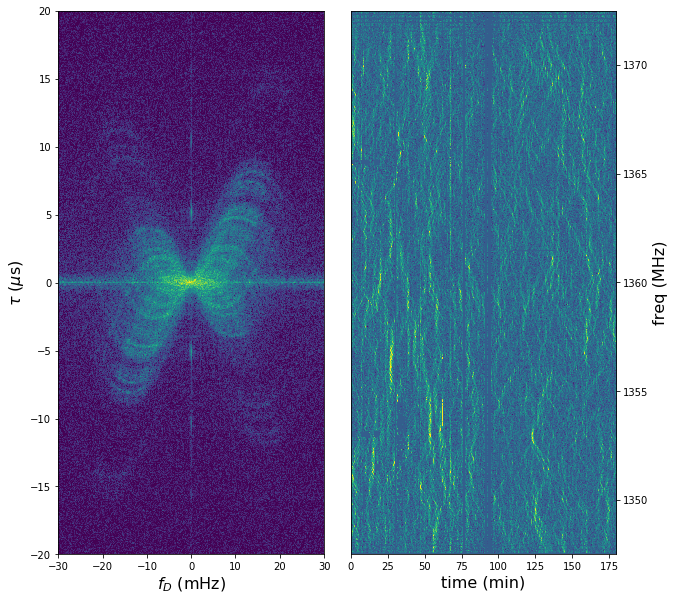

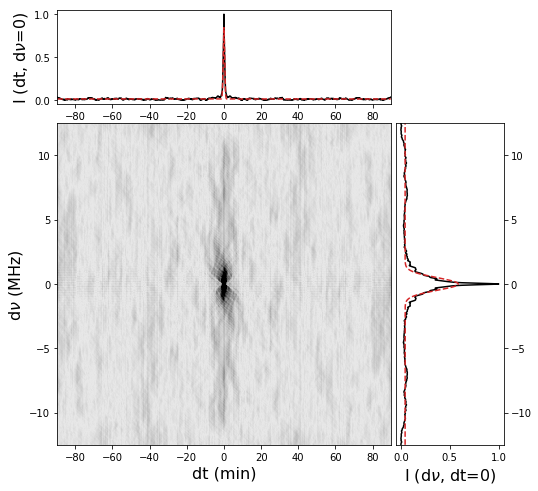

In [33]:
reload(dtools)

fname = '/fpra/bband/01/ramain/Eff_ScintArchives/20201110/B1508+55/6/2020-11-10-10:20:50.ar'
I, F, t, psrname, telescope = dtools.readpsrarch(fname)

T = Time(t, format='mjd')
foldspec, flag, mask, bg, bpass= dtools.clean_foldspec(I, plots=True, 
                                 apply_mask=True, rfimethod='var', 
                                 flagval=7, offpulse='True', tolerance=0.7)

dynspec = dtools.create_dynspec(foldspec)
Funits = F*u.MHz

dt = (T[1]-T[0]).to(u.s)
bintau = 2
binft = 2
CS, ft, tau = dtools.plot_secspec(dynspec, F, dt=dt, binft=binft,
                       bintau=bintau, vm=4., xlim=30, ylim=20)

ccorr, fscint, fscinterr, tscint, tscinterr = dtools.Gaussfit(dynspec, df, dt)

print("df = {0} +- {1} MHz".format(fscint, fscinterr))
print("dt = {0} +- {1}, seconds".format(tscint, tscinterr))

# We can measure scintillation parameters! Why is this cool?

If you care only about precision timing, then you can measure the variable scattering over time $\tau_{scat} \approx 1 / (2 \pi \nu_{scint})$, or by integrating the secondary spectrum  (eg. Hemberger & Stinebring 2008, Levin et al. 2016, Main et al 2020)


The scintillation timescale / arc curvature encodes the pulsar and Earth's velocity - modelling annual changes in the scintillation timescale gives the screen distance and orientation.  If in a binary, then how scintillation timescale changes over the orbit depends on $i$ and $\Omega$  ( eg. Rickett et al. 2014, Reardon et al. 2019, 2020 )

Typically, arc curvatures behave much better than scint velocities!  

See also the Annual_Scintillation notebook, and there is a nice example notebook and code in Daniel Reardon's "scintools" package:  https://github.com/danielreardon/scintools


# Write out the dynspec as a psrflux format dynamic spectrum

In [43]:
dtools.write_psrflux(dynspec, np.zeros_like(dynspec), Funits, T, fname='2020-11-10-10:20:50.dynspec')

Written dynspec to 2020-11-10-10:20:50.dynspec
